# UserBasicClassifier
Un classificador básico con la matadata del usuario

In [264]:
!pip install --upgrade pip
import pandas as pd
import numpy as np

import os
import pickle

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3
  Rolling back uninstall of pip
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip3.6.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip3.6.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip3.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip3.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\site-packages\pip-19.0.3.dist-info\
   from c:\users\matias\appdata\roaming\python\python36\site-packages\~ip-19.0.3.dist-info
  Moving to c:\users\matias\appdata\roaming\python\python36\site-packages\pip\
   from c:\users\matias\appdata\roaming\python\python36\site-packages\~ip


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\Lib\\site-packages\\pip\\__init__.py'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
users = pd.read_pickle('trainDatasets/users_dataset.pkl')

In [5]:
users.head()

,id,screen_name,complete_name,description,verified,crawled_at,location,url,created_at,tweet_count,listed_count,favs_count,followers_count,following_count,bot,user_type
24858289,24858289,davideb66,Davide Bertoli,NaN,NaN,2014-04-19 14:46:19,NaN,NaN,Tue Mar 17 08:51:12 +0000 2009,1299,0,1,22,40,True,Spambot_1
33212890,33212890,ElisaDospina,Elisa D'Ospina,Autrice del libro #unavitatuttacurve dal 9 apr...,NaN,2014-05-18 23:20:58,Italy,http://t.co/ceK8TovxwI,Sun Apr 19 14:38:04 +0000 2009,18665,110,16358,12561,3442,True,Spambot_1
39773427,39773427,Vladimir65,Donato Vincenzo,[Live Long and Prosper],NaN,2014-05-13 23:21:54,"iPhone: 45.471680,9.192429",NaN,Wed May 13 15:34:41 +0000 2009,22987,6,14,600,755,True,Spambot_1
57007623,57007623,RafielaMorales,Rafiela Morales L.,"Cuasi Odontologa*♥,#Bipolar, #Sarcastica & Som...",NaN,2014-05-19 23:24:18,"ÜT: 18.4698712,-69.9327525",NaN,Wed Jul 15 12:55:03 +0000 2009,7975,2,11,398,350,True,Spambot_1
63258466,63258466,FabrizioC_c,§ h a † u r♄,"I shall rise from my own death, to avenge hers...",NaN,2014-05-11 23:22:23,Firenze,http://t.co/PK5F0JDKcy,Wed Aug 05 21:12:49 +0000 2009,20218,8,162,413,405,True,Spambot_1


In [279]:
def transform_x(df):
    df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_convert(tz='UTC')
    df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_convert(tz='UTC')
    account_life = df.crawled_at - df.created_at
    account_life_meses = np.round(account_life.dt.days / 30)
    account_life_meses = account_life_meses.replace(0, 1)
    account_life_semanas = np.round(account_life.dt.days / 7)
    account_life_semanas = account_life_semanas.replace(0, 1)
    numValues = ['tweet_count', 'listed_count', 'favs_count', 'followers_count', 'following_count']
    for i in numValues:
        colName_mes = i+'_mes'
        df.loc[:,colName_mes] = df[i] / account_life_meses

        colName_semana = i+'_semana'
        df.loc[:,colName_semana] = df[i] / account_life_semanas

    df.loc[:,'verified'] = ~df.verified.isna()
    df.loc[:,'description'] = ~df.description.isna()
    df.loc[:,'location'] = ~df.location.isna()
    df.loc[:,'url'] = ~df.url.isna()

    columnas = np.concatenate(
        [[x, x+'_mes', x+'_semana'] for x in numValues]
    )
    columnas = np.concatenate([
        [
            'verified',
            'description',
            'location',
            'url',
        ],
        columnas
    ])
    df = df[columnas]
    df = df.fillna(0)
    return df
    
#     def fit(self, x, y=0):
#         return self
#     def transform(self, x, y=0):
#         x = self.getVars(x)
#         return x
#     def fit_transform(self, x, y=0):
#         x = self.getVars(x)
#         return x

In [287]:
pipeline = Pipeline([
#     ('scaler', StandardScaler()),
    ('cat', CatBoostClassifier())
])

le = preprocessing.LabelEncoder()
x = transform_x(users)
y =  le.fit_transform(users['bot'])

X_train, X_test, y_train, y_test = train_test_split(x, y)

pipeline.fit(X_train, y_train)

Learning rate set to 0.028192
0:	learn: 0.6312749	total: 53.3ms	remaining: 53.3s
1:	learn: 0.5812948	total: 91.5ms	remaining: 45.7s
2:	learn: 0.5357572	total: 130ms	remaining: 43.2s
3:	learn: 0.4929018	total: 167ms	remaining: 41.6s
4:	learn: 0.4487725	total: 209ms	remaining: 41.7s
5:	learn: 0.4110927	total: 245ms	remaining: 40.7s
6:	learn: 0.3815276	total: 285ms	remaining: 40.4s
7:	learn: 0.3547291	total: 327ms	remaining: 40.5s
8:	learn: 0.3302145	total: 365ms	remaining: 40.2s
9:	learn: 0.3041434	total: 401ms	remaining: 39.7s
10:	learn: 0.2835013	total: 443ms	remaining: 39.8s
11:	learn: 0.2635276	total: 479ms	remaining: 39.4s
12:	learn: 0.2458642	total: 525ms	remaining: 39.8s
13:	learn: 0.2306529	total: 561ms	remaining: 39.5s
14:	learn: 0.2157521	total: 597ms	remaining: 39.2s
15:	learn: 0.2021197	total: 639ms	remaining: 39.3s
16:	learn: 0.1914272	total: 674ms	remaining: 39s
17:	learn: 0.1806516	total: 711ms	remaining: 38.8s
18:	learn: 0.1699996	total: 748ms	remaining: 38.6s
19:	learn: 

161:	learn: 0.0433619	total: 6.08s	remaining: 31.4s
162:	learn: 0.0432468	total: 6.12s	remaining: 31.4s
163:	learn: 0.0431370	total: 6.16s	remaining: 31.4s
164:	learn: 0.0431017	total: 6.19s	remaining: 31.3s
165:	learn: 0.0430257	total: 6.23s	remaining: 31.3s
166:	learn: 0.0429845	total: 6.27s	remaining: 31.3s
167:	learn: 0.0429212	total: 6.3s	remaining: 31.2s
168:	learn: 0.0428377	total: 6.34s	remaining: 31.2s
169:	learn: 0.0427931	total: 6.38s	remaining: 31.1s
170:	learn: 0.0427480	total: 6.41s	remaining: 31.1s
171:	learn: 0.0426464	total: 6.45s	remaining: 31.1s
172:	learn: 0.0426121	total: 6.49s	remaining: 31s
173:	learn: 0.0425054	total: 6.52s	remaining: 31s
174:	learn: 0.0424604	total: 6.56s	remaining: 30.9s
175:	learn: 0.0424156	total: 6.59s	remaining: 30.9s
176:	learn: 0.0423841	total: 6.64s	remaining: 30.9s
177:	learn: 0.0423340	total: 6.68s	remaining: 30.8s
178:	learn: 0.0422860	total: 6.72s	remaining: 30.8s
179:	learn: 0.0422706	total: 6.75s	remaining: 30.8s
180:	learn: 0.042

320:	learn: 0.0356139	total: 11.9s	remaining: 25.2s
321:	learn: 0.0355840	total: 12s	remaining: 25.3s
322:	learn: 0.0355087	total: 12s	remaining: 25.2s
323:	learn: 0.0354547	total: 12.1s	remaining: 25.2s
324:	learn: 0.0354258	total: 12.1s	remaining: 25.1s
325:	learn: 0.0354006	total: 12.1s	remaining: 25.1s
326:	learn: 0.0353515	total: 12.2s	remaining: 25.1s
327:	learn: 0.0352770	total: 12.3s	remaining: 25.2s
328:	learn: 0.0352717	total: 12.3s	remaining: 25.2s
329:	learn: 0.0352617	total: 12.4s	remaining: 25.1s
330:	learn: 0.0352547	total: 12.4s	remaining: 25.1s
331:	learn: 0.0352237	total: 12.5s	remaining: 25.1s
332:	learn: 0.0352149	total: 12.5s	remaining: 25s
333:	learn: 0.0351636	total: 12.5s	remaining: 24.9s
334:	learn: 0.0350457	total: 12.5s	remaining: 24.9s
335:	learn: 0.0350382	total: 12.6s	remaining: 24.9s
336:	learn: 0.0350020	total: 12.6s	remaining: 24.8s
337:	learn: 0.0349692	total: 12.7s	remaining: 24.9s
338:	learn: 0.0349435	total: 12.8s	remaining: 24.9s
339:	learn: 0.0349

479:	learn: 0.0314032	total: 18.4s	remaining: 20s
480:	learn: 0.0313996	total: 18.5s	remaining: 20s
481:	learn: 0.0313909	total: 18.6s	remaining: 20s
482:	learn: 0.0313728	total: 18.6s	remaining: 19.9s
483:	learn: 0.0313370	total: 18.7s	remaining: 19.9s
484:	learn: 0.0313163	total: 18.8s	remaining: 19.9s
485:	learn: 0.0312528	total: 18.8s	remaining: 19.9s
486:	learn: 0.0311950	total: 18.9s	remaining: 19.9s
487:	learn: 0.0311287	total: 18.9s	remaining: 19.9s
488:	learn: 0.0311176	total: 19s	remaining: 19.9s
489:	learn: 0.0311144	total: 19.1s	remaining: 19.8s
490:	learn: 0.0310988	total: 19.1s	remaining: 19.8s
491:	learn: 0.0310338	total: 19.2s	remaining: 19.8s
492:	learn: 0.0310069	total: 19.2s	remaining: 19.8s
493:	learn: 0.0309910	total: 19.3s	remaining: 19.8s
494:	learn: 0.0309809	total: 19.4s	remaining: 19.7s
495:	learn: 0.0309601	total: 19.4s	remaining: 19.7s
496:	learn: 0.0309476	total: 19.5s	remaining: 19.7s
497:	learn: 0.0309385	total: 19.5s	remaining: 19.7s
498:	learn: 0.030938

641:	learn: 0.0285274	total: 25.4s	remaining: 14.2s
642:	learn: 0.0284832	total: 25.4s	remaining: 14.1s
643:	learn: 0.0284809	total: 25.5s	remaining: 14.1s
644:	learn: 0.0284560	total: 25.5s	remaining: 14s
645:	learn: 0.0284526	total: 25.5s	remaining: 14s
646:	learn: 0.0284045	total: 25.6s	remaining: 14s
647:	learn: 0.0283808	total: 25.6s	remaining: 13.9s
648:	learn: 0.0283674	total: 25.7s	remaining: 13.9s
649:	learn: 0.0283661	total: 25.7s	remaining: 13.8s
650:	learn: 0.0283649	total: 25.7s	remaining: 13.8s
651:	learn: 0.0283503	total: 25.8s	remaining: 13.8s
652:	learn: 0.0282804	total: 25.8s	remaining: 13.7s
653:	learn: 0.0282785	total: 25.9s	remaining: 13.7s
654:	learn: 0.0282764	total: 25.9s	remaining: 13.6s
655:	learn: 0.0282565	total: 25.9s	remaining: 13.6s
656:	learn: 0.0282403	total: 26s	remaining: 13.6s
657:	learn: 0.0282232	total: 26s	remaining: 13.5s
658:	learn: 0.0282013	total: 26s	remaining: 13.5s
659:	learn: 0.0281235	total: 26.1s	remaining: 13.4s
660:	learn: 0.0281227	to

803:	learn: 0.0262918	total: 31.6s	remaining: 7.71s
804:	learn: 0.0262762	total: 31.7s	remaining: 7.67s
805:	learn: 0.0262559	total: 31.7s	remaining: 7.63s
806:	learn: 0.0262540	total: 31.7s	remaining: 7.59s
807:	learn: 0.0262525	total: 31.8s	remaining: 7.55s
808:	learn: 0.0262507	total: 31.8s	remaining: 7.51s
809:	learn: 0.0261859	total: 31.9s	remaining: 7.47s
810:	learn: 0.0261358	total: 31.9s	remaining: 7.43s
811:	learn: 0.0261290	total: 31.9s	remaining: 7.39s
812:	learn: 0.0260923	total: 32s	remaining: 7.36s
813:	learn: 0.0260904	total: 32s	remaining: 7.32s
814:	learn: 0.0260704	total: 32.1s	remaining: 7.28s
815:	learn: 0.0260684	total: 32.1s	remaining: 7.24s
816:	learn: 0.0260473	total: 32.1s	remaining: 7.2s
817:	learn: 0.0260169	total: 32.2s	remaining: 7.16s
818:	learn: 0.0259969	total: 32.2s	remaining: 7.12s
819:	learn: 0.0259950	total: 32.3s	remaining: 7.08s
820:	learn: 0.0259882	total: 32.3s	remaining: 7.04s
821:	learn: 0.0259865	total: 32.4s	remaining: 7s
822:	learn: 0.025985

966:	learn: 0.0246543	total: 37.8s	remaining: 1.29s
967:	learn: 0.0246465	total: 37.9s	remaining: 1.25s
968:	learn: 0.0246432	total: 37.9s	remaining: 1.21s
969:	learn: 0.0246313	total: 37.9s	remaining: 1.17s
970:	learn: 0.0246294	total: 38s	remaining: 1.13s
971:	learn: 0.0246293	total: 38s	remaining: 1.09s
972:	learn: 0.0246249	total: 38s	remaining: 1.05s
973:	learn: 0.0245351	total: 38.1s	remaining: 1.02s
974:	learn: 0.0245284	total: 38.1s	remaining: 977ms
975:	learn: 0.0245281	total: 38.2s	remaining: 938ms
976:	learn: 0.0245013	total: 38.2s	remaining: 899ms
977:	learn: 0.0244811	total: 38.2s	remaining: 860ms
978:	learn: 0.0244802	total: 38.3s	remaining: 821ms
979:	learn: 0.0244372	total: 38.3s	remaining: 782ms
980:	learn: 0.0244349	total: 38.4s	remaining: 743ms
981:	learn: 0.0244339	total: 38.4s	remaining: 704ms
982:	learn: 0.0244165	total: 38.4s	remaining: 665ms
983:	learn: 0.0244161	total: 38.5s	remaining: 626ms
984:	learn: 0.0244150	total: 38.5s	remaining: 586ms
985:	learn: 0.0244

Pipeline(memory=None,
     steps=[('cat', <catboost.core.CatBoostClassifier object at 0x0000023E801995C0>)])

El valor del AUC es:  0.9979874843180596


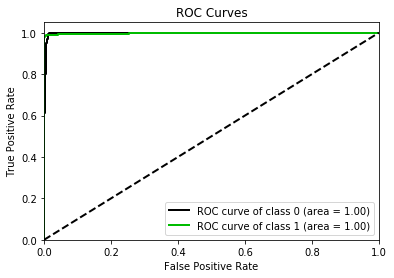

In [288]:
y_predicted_cat = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import roc_auc_score
cat_auc = roc_auc_score(y_test,y_predicted_cat[:,1])
print("El valor del AUC es: ", cat_auc)
from scikitplot.metrics import plot_roc
%matplotlib inline
plot_roc(y_test,y_predicted_cat, plot_micro = False, plot_macro= False)

In [289]:
# Matriz de Confusión
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+str(c) for c in le.classes_]
display(pd.DataFrame(conf, index= ['real_Human','real_Bot'],columns = ['pred_Human','pred_Bot']))
print(classification_report(y_test, y_pred))

,pred_Human,pred_Bot
real_Human,873,8
real_Bot,15,1201


             precision    recall  f1-score   support

          0       0.98      0.99      0.99       881
          1       0.99      0.99      0.99      1216

avg / total       0.99      0.99      0.99      2097



In [290]:
# Re-Entrenar con el dataset completo
modelo = pipeline.fit(transform_x(users), y)

Learning rate set to 0.030584
0:	learn: 0.6348628	total: 55.1ms	remaining: 55s
1:	learn: 0.5733445	total: 122ms	remaining: 1m
2:	learn: 0.5064493	total: 181ms	remaining: 1m
3:	learn: 0.4642480	total: 227ms	remaining: 56.6s
4:	learn: 0.4203130	total: 268ms	remaining: 53.2s
5:	learn: 0.3868924	total: 308ms	remaining: 51s
6:	learn: 0.3568709	total: 349ms	remaining: 49.5s
7:	learn: 0.3268826	total: 392ms	remaining: 48.6s
8:	learn: 0.2997187	total: 435ms	remaining: 47.9s
9:	learn: 0.2782672	total: 477ms	remaining: 47.2s
10:	learn: 0.2583182	total: 519ms	remaining: 46.7s
11:	learn: 0.2392998	total: 560ms	remaining: 46.1s
12:	learn: 0.2220446	total: 605ms	remaining: 46s
13:	learn: 0.2066830	total: 648ms	remaining: 45.7s
14:	learn: 0.1946488	total: 689ms	remaining: 45.2s
15:	learn: 0.1816697	total: 729ms	remaining: 44.8s
16:	learn: 0.1713181	total: 769ms	remaining: 44.5s
17:	learn: 0.1617456	total: 812ms	remaining: 44.3s
18:	learn: 0.1537467	total: 862ms	remaining: 44.5s
19:	learn: 0.1447541	t

164:	learn: 0.0408729	total: 7.04s	remaining: 35.6s
165:	learn: 0.0408587	total: 7.08s	remaining: 35.6s
166:	learn: 0.0407733	total: 7.12s	remaining: 35.5s
167:	learn: 0.0406836	total: 7.16s	remaining: 35.5s
168:	learn: 0.0405986	total: 7.2s	remaining: 35.4s
169:	learn: 0.0404874	total: 7.25s	remaining: 35.4s
170:	learn: 0.0404628	total: 7.29s	remaining: 35.3s
171:	learn: 0.0403488	total: 7.35s	remaining: 35.4s
172:	learn: 0.0403177	total: 7.4s	remaining: 35.4s
173:	learn: 0.0402767	total: 7.45s	remaining: 35.3s
174:	learn: 0.0402057	total: 7.49s	remaining: 35.3s
175:	learn: 0.0401903	total: 7.53s	remaining: 35.3s
176:	learn: 0.0400718	total: 7.57s	remaining: 35.2s
177:	learn: 0.0400151	total: 7.61s	remaining: 35.1s
178:	learn: 0.0399403	total: 7.65s	remaining: 35.1s
179:	learn: 0.0398985	total: 7.7s	remaining: 35.1s
180:	learn: 0.0398349	total: 7.74s	remaining: 35s
181:	learn: 0.0397657	total: 7.78s	remaining: 35s
182:	learn: 0.0396802	total: 7.82s	remaining: 34.9s
183:	learn: 0.03967

325:	learn: 0.0344090	total: 14s	remaining: 29s
326:	learn: 0.0343998	total: 14.1s	remaining: 29s
327:	learn: 0.0343772	total: 14.2s	remaining: 29s
328:	learn: 0.0343725	total: 14.2s	remaining: 29s
329:	learn: 0.0343343	total: 14.2s	remaining: 28.9s
330:	learn: 0.0343024	total: 14.3s	remaining: 28.9s
331:	learn: 0.0343010	total: 14.3s	remaining: 28.8s
332:	learn: 0.0342809	total: 14.4s	remaining: 28.7s
333:	learn: 0.0342775	total: 14.4s	remaining: 28.7s
334:	learn: 0.0342340	total: 14.4s	remaining: 28.6s
335:	learn: 0.0342223	total: 14.5s	remaining: 28.6s
336:	learn: 0.0341983	total: 14.5s	remaining: 28.5s
337:	learn: 0.0341900	total: 14.5s	remaining: 28.5s
338:	learn: 0.0341510	total: 14.6s	remaining: 28.5s
339:	learn: 0.0341499	total: 14.6s	remaining: 28.4s
340:	learn: 0.0341303	total: 14.7s	remaining: 28.3s
341:	learn: 0.0341201	total: 14.7s	remaining: 28.3s
342:	learn: 0.0341135	total: 14.7s	remaining: 28.2s
343:	learn: 0.0340864	total: 14.8s	remaining: 28.2s
344:	learn: 0.0340759	

486:	learn: 0.0301658	total: 20.7s	remaining: 21.8s
487:	learn: 0.0301417	total: 20.8s	remaining: 21.8s
488:	learn: 0.0301221	total: 20.8s	remaining: 21.7s
489:	learn: 0.0300980	total: 20.9s	remaining: 21.7s
490:	learn: 0.0300779	total: 20.9s	remaining: 21.7s
491:	learn: 0.0300596	total: 20.9s	remaining: 21.6s
492:	learn: 0.0299958	total: 21s	remaining: 21.6s
493:	learn: 0.0299707	total: 21s	remaining: 21.5s
494:	learn: 0.0299581	total: 21.1s	remaining: 21.5s
495:	learn: 0.0299505	total: 21.1s	remaining: 21.5s
496:	learn: 0.0299207	total: 21.2s	remaining: 21.4s
497:	learn: 0.0298924	total: 21.2s	remaining: 21.4s
498:	learn: 0.0298726	total: 21.2s	remaining: 21.3s
499:	learn: 0.0298442	total: 21.3s	remaining: 21.3s
500:	learn: 0.0298421	total: 21.3s	remaining: 21.2s
501:	learn: 0.0298354	total: 21.4s	remaining: 21.2s
502:	learn: 0.0298272	total: 21.4s	remaining: 21.1s
503:	learn: 0.0298197	total: 21.4s	remaining: 21.1s
504:	learn: 0.0298060	total: 21.5s	remaining: 21.1s
505:	learn: 0.02

648:	learn: 0.0268293	total: 27.5s	remaining: 14.9s
649:	learn: 0.0268286	total: 27.5s	remaining: 14.8s
650:	learn: 0.0268089	total: 27.6s	remaining: 14.8s
651:	learn: 0.0267930	total: 27.6s	remaining: 14.7s
652:	learn: 0.0267856	total: 27.7s	remaining: 14.7s
653:	learn: 0.0267822	total: 27.7s	remaining: 14.7s
654:	learn: 0.0267667	total: 27.8s	remaining: 14.6s
655:	learn: 0.0267571	total: 27.8s	remaining: 14.6s
656:	learn: 0.0267547	total: 27.8s	remaining: 14.5s
657:	learn: 0.0267478	total: 27.9s	remaining: 14.5s
658:	learn: 0.0267442	total: 27.9s	remaining: 14.4s
659:	learn: 0.0267123	total: 28s	remaining: 14.4s
660:	learn: 0.0267105	total: 28s	remaining: 14.4s
661:	learn: 0.0267051	total: 28s	remaining: 14.3s
662:	learn: 0.0267015	total: 28.1s	remaining: 14.3s
663:	learn: 0.0266979	total: 28.1s	remaining: 14.2s
664:	learn: 0.0266656	total: 28.2s	remaining: 14.2s
665:	learn: 0.0266625	total: 28.2s	remaining: 14.1s
666:	learn: 0.0266501	total: 28.2s	remaining: 14.1s
667:	learn: 0.0266

811:	learn: 0.0246178	total: 34.3s	remaining: 7.95s
812:	learn: 0.0246162	total: 34.4s	remaining: 7.9s
813:	learn: 0.0246139	total: 34.4s	remaining: 7.86s
814:	learn: 0.0245890	total: 34.4s	remaining: 7.82s
815:	learn: 0.0245880	total: 34.5s	remaining: 7.77s
816:	learn: 0.0245379	total: 34.5s	remaining: 7.73s
817:	learn: 0.0245353	total: 34.6s	remaining: 7.69s
818:	learn: 0.0245129	total: 34.6s	remaining: 7.65s
819:	learn: 0.0244888	total: 34.7s	remaining: 7.61s
820:	learn: 0.0244880	total: 34.7s	remaining: 7.56s
821:	learn: 0.0244874	total: 34.7s	remaining: 7.52s
822:	learn: 0.0244487	total: 34.8s	remaining: 7.48s
823:	learn: 0.0244466	total: 34.8s	remaining: 7.44s
824:	learn: 0.0244428	total: 34.9s	remaining: 7.39s
825:	learn: 0.0244368	total: 34.9s	remaining: 7.35s
826:	learn: 0.0244279	total: 34.9s	remaining: 7.31s
827:	learn: 0.0244193	total: 35s	remaining: 7.27s
828:	learn: 0.0244179	total: 35s	remaining: 7.22s
829:	learn: 0.0244164	total: 35.1s	remaining: 7.18s
830:	learn: 0.024

971:	learn: 0.0231634	total: 40.9s	remaining: 1.18s
972:	learn: 0.0231611	total: 41s	remaining: 1.14s
973:	learn: 0.0231604	total: 41s	remaining: 1.09s
974:	learn: 0.0231528	total: 41.1s	remaining: 1.05s
975:	learn: 0.0231509	total: 41.1s	remaining: 1.01s
976:	learn: 0.0231224	total: 41.1s	remaining: 969ms
977:	learn: 0.0231198	total: 41.2s	remaining: 927ms
978:	learn: 0.0231180	total: 41.2s	remaining: 884ms
979:	learn: 0.0231144	total: 41.3s	remaining: 842ms
980:	learn: 0.0231140	total: 41.3s	remaining: 800ms
981:	learn: 0.0230993	total: 41.4s	remaining: 758ms
982:	learn: 0.0230981	total: 41.4s	remaining: 716ms
983:	learn: 0.0230952	total: 41.4s	remaining: 674ms
984:	learn: 0.0230750	total: 41.5s	remaining: 632ms
985:	learn: 0.0230582	total: 41.5s	remaining: 590ms
986:	learn: 0.0230419	total: 41.6s	remaining: 548ms
987:	learn: 0.0230409	total: 41.6s	remaining: 505ms
988:	learn: 0.0230167	total: 41.7s	remaining: 463ms
989:	learn: 0.0230160	total: 41.7s	remaining: 421ms
990:	learn: 0.02

In [291]:
# Exportar Modelo a archivo binario
filename = 'modelPipeline.pkl'
with open(filename, 'wb') as twModel:
    pickle.dump(modelo, twModel)